<a href="https://colab.research.google.com/github/SauravMaheshkar/optax/blob/master/examples/Optax_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🔧 Basic Setup

In this code cell: 

1. Install the correct version of `JAX` based on the CUDA version of the colab.

2. Install `dm-haiku`, `optax` and `wandb`

3. Setup TPU driver as `jax_xla_backend`

4. Initialize our Weights and Biases Project

5. Setup a Hyperparameter sweep 🧹 to maximize Training Accuracy

In [ ]:
%%capture
# Check CUDA Version (For this instance it was release 10.1)
!nvcc --version

# Install jax and jaxlib (cuda101 because it's release 10.1)
!pip install --upgrade jax jaxlib==0.1.57+cuda101 -f https://storage.googleapis.com/jax-releases/jax_releases.html

# Install dm-haiku
!pip install git+https://github.com/deepmind/dm-haiku

# Install optax
!pip install optax

# Install Weights and Biases to track our experiments, visualize metrics, and share results
!pip install wandb


import os
import jax
import wandb
import optax
import requests
import numpy as np
import haiku as hk
import jax.numpy as jnp
from jax.config import config
from jax import jit, grad, random
import tensorflow_datasets as tfds
from typing import Any, Generator, Mapping, Tuple

OptState = Any
Batch = Mapping[str, np.ndarray]
rng = random.PRNGKey(0)

colab_tpu_addr = os.environ['COLAB_TPU_ADDR'].split(':')[0]
url = f'http://{colab_tpu_addr}:8475/requestversion/tpu_driver_nightly'
requests.post(url)
config.FLAGS.jax_xla_backend = "tpu_driver"
config.FLAGS.jax_backend_target = "grpc://" + os.environ['COLAB_TPU_ADDR']

wandb.init(project="gradient-processing-and-optimization", entity="sauravmaheshkar")

In [ ]:
sweep_config = {
    'method': 'grid', #grid, random
    'metric': {
      'name': 'train_accuracy',
      'goal': 'maximize'   
    },
    'parameters': {
        'epochs': {
            'values': [200, 100, 50]
        },
        'batch_size': {
            'values': [256, 128, 64]
        },
        'learning_rate': {
            'values': [1e-2, 1e-3, 1e-4, 3e-4, 3e-5, 1e-5]
        },
        'weight_decay':{
            'values': [0.0005, 0.005, 0.05]
        },
        'optimizer': {
            'values': ['lamb']
        },
    }
}

sweep_id = wandb.sweep(sweep_config, entity="sauravmaheshkar", project="gradient-processing-and-optimization")

# 💪🏻 Creating the Neural Network

In this cell, we create a function `net_fn(batch)`, which returns the output when the `batch` is fed through the Neural Network.

The function has the following steps:

1. Convert the image to `float32` and then normalize it. 

2. Create a  Standard LeNet-300-100 MLP network by creating an instance of the `hk.Sequential()` Class using `jax.nn.relu` as the activation function between layers

3. Call the instance and return output from the network
 




In [ ]:
def net_fn(batch: Batch) -> jnp.ndarray:
  """
  Standard LeNet-300-100 MLP network.
  Ported from https://github.com/deepmind/dm-haiku/blob/master/examples/mnist.py
  """
  x = batch["image"].astype(jnp.float32) / 255.
  mlp = hk.Sequential([
      hk.Flatten(),
      hk.Linear(300), jax.nn.relu,
      hk.Linear(100), jax.nn.relu,
      hk.Linear(10),
  ])
  return mlp(x)

net = hk.without_apply_rng(hk.transform(net_fn))

# 🏋🏻‍♀️ Import the Dataset

We create a function that loads the dataset as a generator of batches using the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset.

In [ ]:
def load_dataset(
    split: str,
    *,
    is_training: bool,
    batch_size: int,
) -> Generator[Batch, None, None]:

  """
  Loads the dataset as a generator of batches.
  Ported from https://github.com/deepmind/dm-haiku/blob/master/examples/mnist.py
  """
  ds = tfds.load("mnist:3.*.*", split=split).cache().repeat()
  if is_training:
    ds = ds.shuffle(10 * batch_size, seed=0)
  ds = ds.batch(batch_size)
  return iter(tfds.as_numpy(ds))

# ➖ The Loss Function and Accuracy %
 

In [ ]:
def loss_fn(params: hk.Params, batch: Batch) -> jnp.ndarray:
    """Compute the loss of the network, including L2."""
    logits = net.apply(params, batch)
    labels = jax.nn.one_hot(batch["label"], 10)

    l2_loss = 0.5 * sum(jnp.sum(jnp.square(p)) for p in jax.tree_leaves(params))
    softmax_xent = -jnp.sum(labels * jax.nn.log_softmax(logits))
    softmax_xent /= labels.shape[0]

    return softmax_xent + 1e-4 * l2_loss

In [ ]:
@jax.jit
def accuracy(params: hk.Params, batch: Batch) -> jnp.ndarray:
  predictions = net.apply(params, batch)
  return jnp.mean(jnp.argmax(predictions, axis=-1) == batch["label"])

# 🏋️ Training the Model

This is where we use `Optax` for gradient processing and optimization.

* We perform sweeps using all the popular aliases provided in Optax library. [Here](https://github.com/deepmind/optax/blob/master/optax/_src/alias.py)'s the link to view all aliases.

The following are the default configurations used during Training.

```
Epochs: 50
Batch Size: 128
Learning Rate: 1e-3
Weight Decay: 0.0005
```

While using a alias, we get a instance of the Optax `GradientTransformation` class which is just a Function pair containing `(initialise, update)`.

* We then declare a `opt_state` variable intializing the optimizer with the initial parameters.

* Transform the gradients using the optimizer and the parameters obtained during forward pass, and then update the parameters using `optax.apply_updates()` function

In [ ]:
def train():

  config_defaults = {
        'epochs': 50,
        'batch_size': 128,
        'learning_rate': 1e-3,
        'weight_decay': 0.0005
    }


  # Initialize a new wandb run
  wandb.init(config=config_defaults)

  config = wandb.config
  
  opt_init, opt_update = optax.adam(learning_rate = config.learning_rate)

  train = load_dataset("train", is_training=True, batch_size=config.batch_size)
  train_eval = load_dataset("train", is_training=False, batch_size=config.batch_size)
  test_eval = load_dataset("test", is_training=False, batch_size=config.batch_size)

  params = avg_params = net.init(rng, next(train))
  opt_state = opt_init(params)

  for step in range(config.epochs):
    if step % 10 == 0:
      train_accuracy = accuracy(avg_params, next(train_eval))
      test_accuracy = accuracy(avg_params, next(test_eval))
      train_accuracy, test_accuracy = jax.device_get(
            (train_accuracy, test_accuracy))
      wandb.log({"Train Accuracy": float(train_accuracy), "Test Accuracy": float(test_accuracy)})
    grad = jax.grad(loss_fn)(params, next(train))

    # Transform the gradients using the optimiser.
    updates, opt_state = opt_update(grad, opt_state, params)
    # Update parameters.
    params = optax.apply_updates(params, updates)

In [ ]:
wandb.agent(sweep_id, train)

# 📈 Compairing Performance Across Optimizers



## **rmsprop**



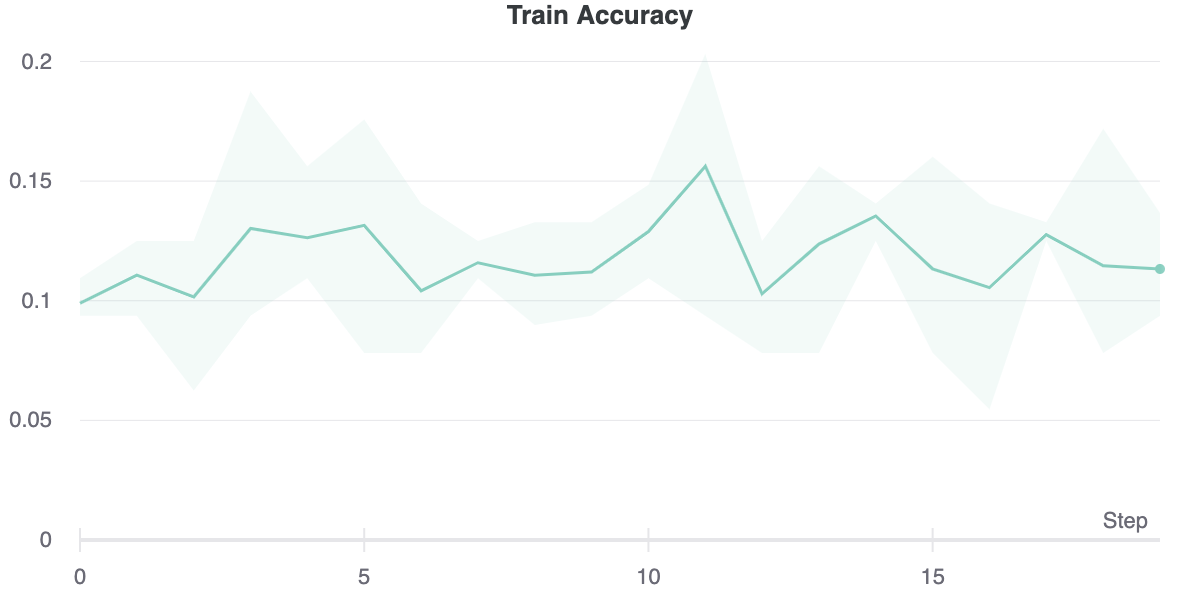

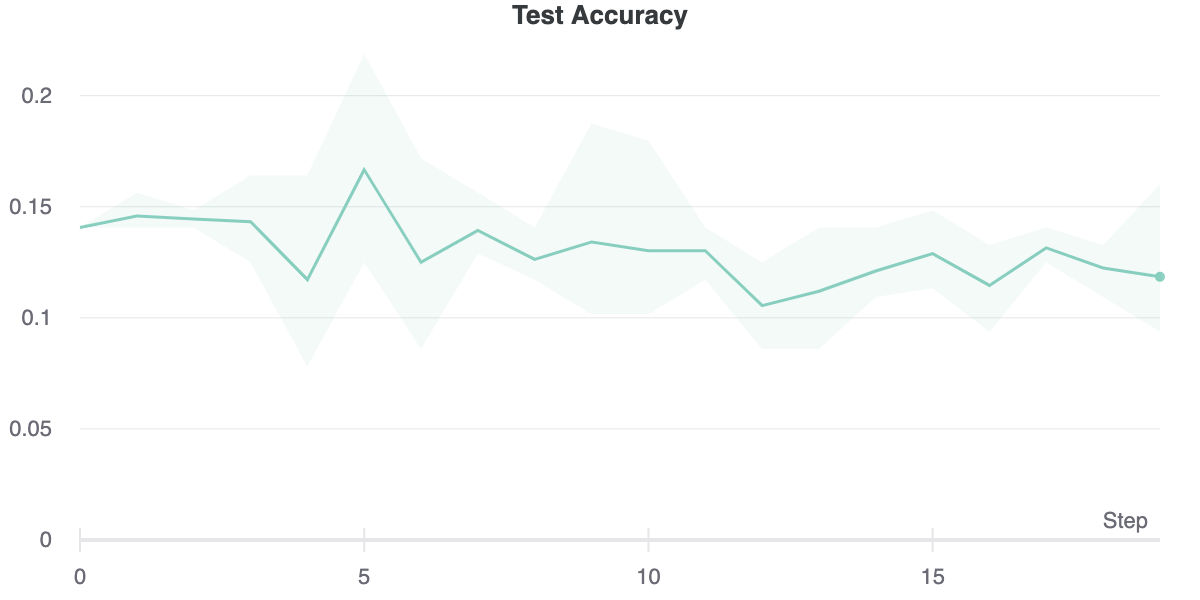

## **lamb**

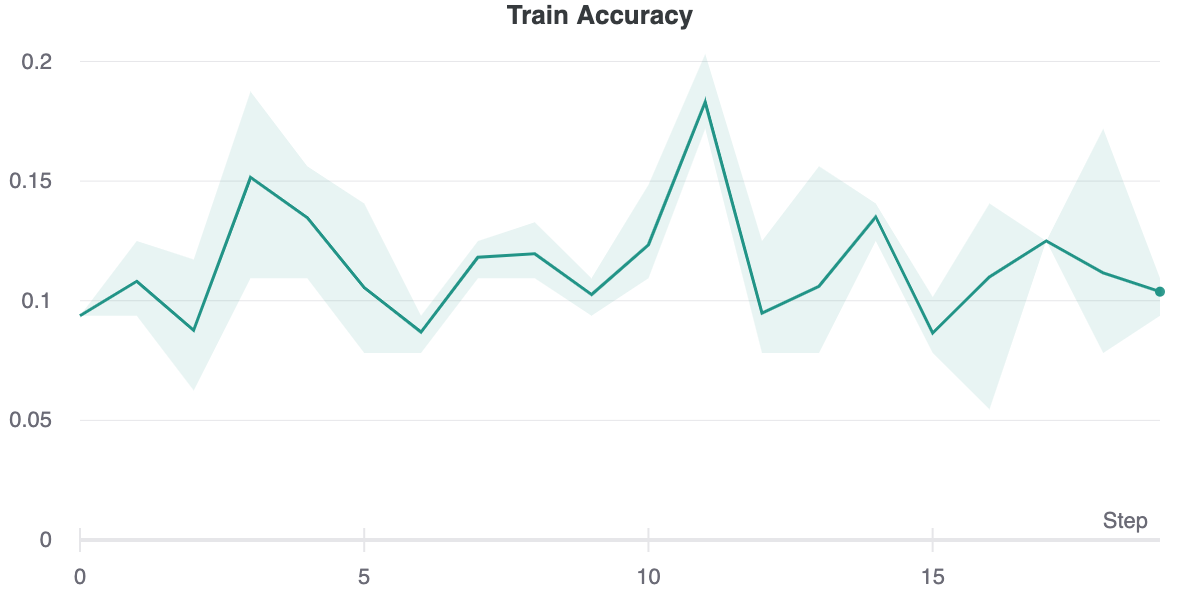

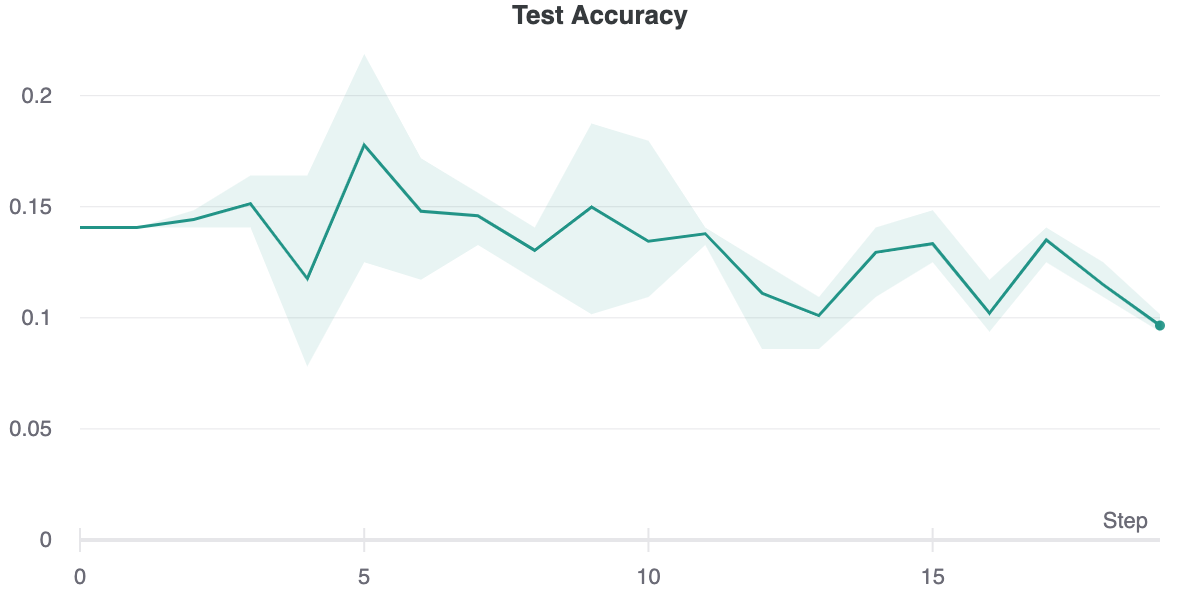

## **SGD vs Noisy SGD**

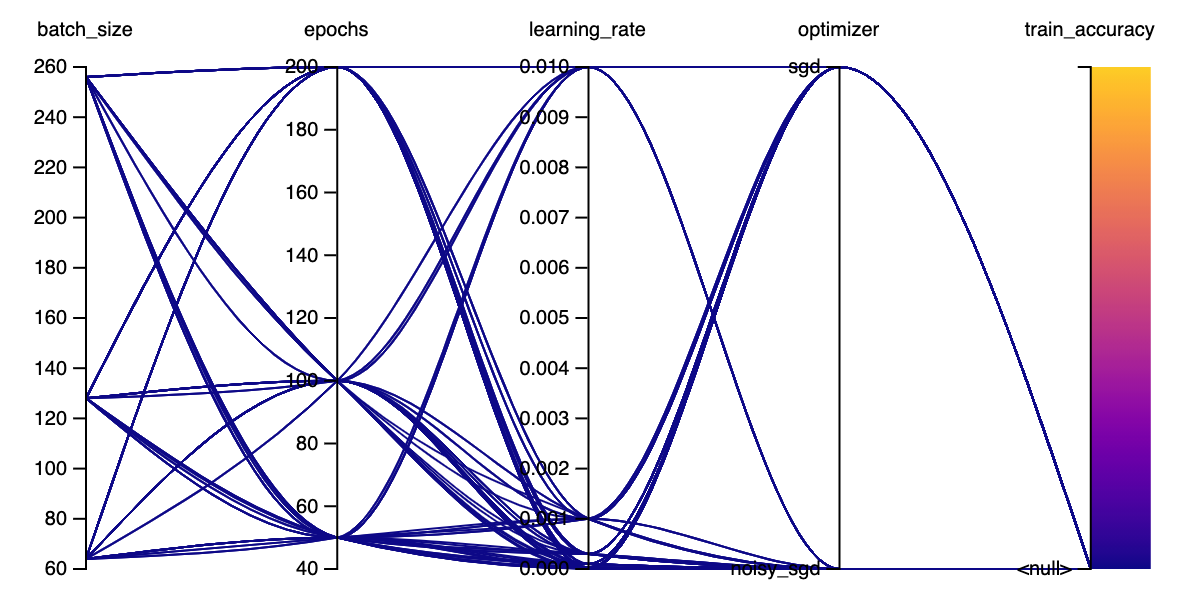

If you want to see all of the different graphs please visit this [Weights and Biases Project Page](https://wandb.ai/sauravmaheshkar/gradient-processing-and-optimization/overview)